# Week 1: Introduction to Astrobiology & Bioinformatics
## Exploring Life at the Extremes with Python

### Learning Objectives:
1. Set up Python environment for bioinformatics analysis
2. Access and retrieve sequences from NCBI databases
3. Perform BLAST searches programmatically
4. Analyze sequences from extremophile organisms
5. Understand the connection between extremophiles and astrobiology

---

### Why Extremophiles Matter for Astrobiology

Extremophiles are organisms that thrive in conditions once thought incompatible with life. They help us understand:
- The limits of life on Earth
- Potential habitability of other worlds
- Biosignatures we might detect on Mars, Europa, or Enceladus
- The origins of life in extreme conditions

Today we'll analyze real sequences from organisms living in conditions analogous to extraterrestrial environments!

## Part 1: Setting Up Our Environment

First, let's install and import the necessary libraries. Run this cell at the beginning of your session.

In [ ]:
# Installation (run once)
#conda create -name astrobiology_workshop python=3.13
#conda activate astrobiology_workshop
#conda install biopython pandas numpy matplotlib seaborn 

In [ ]:
#git clone https://github.com/nkhadland/Astrobiology-Workshop-2025-Hadland.git
#Each week, run: git pull origin main 
#if you make edits, copy the notebooks under new names to preserve the originals

In [4]:
# Import libraries
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from Bio.Align import PairwiseAligner
import math 
# Biopython modules
from Bio import Entrez, SeqIO, Seq
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.SeqUtils import gc_fraction
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Data import CodonTable
import Bio

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# IMPORTANT: Set your email for NCBI
Entrez.email = "nkhadland@arizona.edu"  # Replace with your email!
#Test 

## Part 2: Python Basics for Bioinformatics

Let's start with fundamental Python concepts using biological examples.

In [61]:
# Working with DNA sequences as strings
dna_sequence = "ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG"

print("Original DNA sequence:")
print(dna_sequence)
print(f"Length: {len(dna_sequence)} bp")
print()

# String operations useful for sequences
print("First 10 bases:", dna_sequence[:10])
print("Last 10 bases:", dna_sequence[-10:])
print("Reverse:", dna_sequence[::-1])
print("Lowercase:", dna_sequence.lower())
print()

# Counting nucleotides
nucleotide_counts = Counter(dna_sequence)
print("Nucleotide composition:")
for base, count in sorted(nucleotide_counts.items()):
    percentage = (count / len(dna_sequence)) * 100
    print(f"  {base}: {count} ({percentage:.1f}%)")

Original DNA sequence:
ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG
Length: 39 bp

First 10 bases: ATGGCCATTG
Last 10 bases: TGCCCGATAG
Reverse: GATAGCCCGTGGGAAAGTCGCCGGGTAATGTTACCGGTA
Lowercase: atggccattgtaatgggccgctgaaagggtgcccgatag

Nucleotide composition:
  A: 9 (23.1%)
  C: 8 (20.5%)
  G: 14 (35.9%)
  T: 8 (20.5%)


GC content in extremophiles is a complex genomic adaptation where high-temperature organisms, or thermophiles, often have higher GC content, while organisms adapted to cold (psychrophiles) tend to have lower GC content. This is because GC pairs are more stable than AT pairs, a feature beneficial for withstanding extreme heat. The relationship is not universal across all extremophiles and can be influenced by factors like pH, pressure, and salinity. 

<div>
<img src="DNA_base-pair_diagram.jpg" width="1000"/>
</div>



<div style="background-color: white; display: inline-block; padding: 4px;">
  <img src="4ede5a3218abe1404fddd1d998c33db42aebe2c5.png" width="400">
</div>

## Central Dogma of Molecular Biology

The **central dogma** describes the flow of genetic information in biological systems:

**DNA → RNA → Protein**

- **DNA (Deoxyribonucleic Acid)**: The genetic blueprint stored in the nucleus, containing genes that encode instructions for building proteins
- **Transcription**: DNA is copied into RNA (messenger RNA, mRNA) by RNA polymerase
- **Translation**: mRNA is read by ribosomes to synthesize proteins using transfer RNA (tRNA) and amino acids

This unidirectional flow (with some exceptions like reverse transcription in retroviruses) is fundamental to understanding gene expression and regulation in all living organisms.

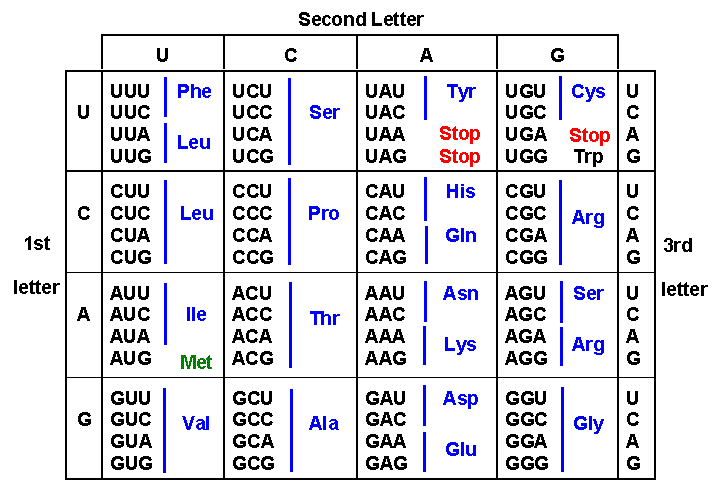

In [62]:

def calculate_gc_content(sequence):
    """Calculate GC content of a DNA sequence.
    
    High GC content is often found in thermophiles!
    """
    sequence = sequence.upper()
    gc_count = sequence.count('G') + sequence.count('C')
    return (gc_count / len(sequence)) * 100

# Test our functions
test_sequence = "ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAGTAGATCGATCGATCGTAGCTAGCTAGCTAG"
print(f"GC content: {calculate_gc_content(test_sequence):.2f}%")


GC content: 52.17%


## Part 3: Accessing NCBI Databases

Let's retrieve real protein sequences from extremophiles! We'll look at:
1. **Deinococcus radiodurans** - Radiation resistant 
2. **Pyrococcus furiosus** - Hyperthermophile 
3. **Psychrobacter arcticus** - Psychrophile 

In [63]:
def fetch_sequence_from_ncbi(accession, db="protein"):
    """Fetch a sequence from NCBI using its accession number.
    
    Parameters:
    -----------
    accession : str
        The accession number (e.g., 'WP_294652' for protein, 'NC_001263' for nucleotide)
    db : str
        Database to search - 'protein' for protein accessions (NP_, WP_, etc.)
                           - 'nucleotide' for nucleotide accessions (NC_, NT_, etc.)
    
    Returns:
    --------
    SeqRecord object or None if fetch fails
    """
    try:
        print(f"Fetching {accession} from NCBI {db} database...")
        handle = Entrez.efetch(db=db, id=accession, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        handle.close()
        print(f"✓ Successfully fetched {accession} ({len(record.seq)} amino acids)")
        return record
    except Exception as e:
        print(f"✗ Error fetching sequence: {e}")
        return None

# Define extremophile proteins to analyze
extremophile_genes = {
    "Deinococcus radiodurans RecA": "WP_010888966.1",  # DNA repair protein
    "Pyrococcus furiosus DNA polymerase": "WP_014835497.1",  # Heat-stable polymerase
    "Psychrobacter arcticus cold shock protein": "WP_011280218.1"  # Cold adaptation
}

sequences = {}
for name, accession in extremophile_genes.items():
    print(f"\n{'='*60}")
    print(f"Searching for: {name}")
    print(f"{'='*60}")
    
    time.sleep(0.5)  # Be nice to NCBI servers
    
    record = fetch_sequence_from_ncbi(accession, db="protein")
    if record:
        sequences[name] = record
 
print(f"\n{'='*60}")
print(f"✅ {len(sequences)}/{len(extremophile_genes)} sequences successfully fetched!")
print(f"{'='*60}")


Searching for: Deinococcus radiodurans RecA
Fetching WP_010888966.1 from NCBI protein database...
✓ Successfully fetched WP_010888966.1 (363 amino acids)

Searching for: Pyrococcus furiosus DNA polymerase
Fetching WP_014835497.1 from NCBI protein database...
✓ Successfully fetched WP_014835497.1 (1263 amino acids)

Searching for: Psychrobacter arcticus cold shock protein
Fetching WP_011280218.1 from NCBI protein database...
✓ Successfully fetched WP_011280218.1 (71 amino acids)

✅ 3/3 sequences successfully fetched!


In [64]:
# Analyze each protein sequence
for name, record in sequences.items():
    print(f"\n{'='*60}")
    print(f"Analysis: {name}")
    print(f"{'='*60}")
    print(f"Accession: {record.id}")
    print(f"Length: {len(record.seq)} amino acids")
    print(f"Description: {record.description}")
    
    # Protein analysis
    analyzed_seq = ProteinAnalysis(str(record.seq))
    print(f"\nMolecular Weight: {analyzed_seq.molecular_weight():.2f} Da")
    # print(f"Isoelectric Point (pI): {analyzed_seq.isoelectric_point():.2f}")
    # print(f"Instability Index: {analyzed_seq.instability_index():.2f}")
    # print(f"GRAVY (hydropathy): {analyzed_seq.gravy():.3f}")
    print(f"{str(record.seq)[:100]}...")
    print(f"(showing first 100 of {len(record.seq)} amino acids)")
    # Amino acid composition
    aa_comp = analyzed_seq.get_amino_acids_percent()
    print(f"\nTop 5 most abundant amino acids:")
    for aa, percent in sorted(aa_comp.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {aa}: {percent*100:.1f}%")


Analysis: Deinococcus radiodurans RecA
Accession: WP_010888966.1
Length: 363 amino acids
Description: recombinase RecA [Deinococcus radiodurans]

Molecular Weight: 38144.30 Da
MSKDATKEISAPTDAKERSKAIETAMSQIEKAFGKGSIMKLGAESKLDVQVVSTGSLSLDLALGVGGIPRGRITEIYGPESGGKTTLALAIVAQAQKAGG...
(showing first 100 of 363 amino acids)

Top 5 most abundant amino acids:
  A: 14.6%
  G: 9.6%
  L: 8.3%
  E: 7.4%
  V: 7.4%

Analysis: Pyrococcus furiosus DNA polymerase
Accession: WP_014835497.1
Length: 1263 amino acids
Description: MULTISPECIES: DNA polymerase II large subunit [Pyrococcus]

Molecular Weight: 143167.17 Da
MELPKEIEEYFEMLQREIDKAYEIAKKARSQGKDPSTDVEIPQATDMAGRVESLVGPPGVAQRIRELLKEYDKEIVALKIVDEIIEGKFGDFGSKEKYAE...
(showing first 100 of 1263 amino acids)

Top 5 most abundant amino acids:
  E: 10.5%
  L: 9.3%
  K: 9.1%
  V: 7.7%
  G: 7.4%

Analysis: Psychrobacter arcticus cold shock protein
Accession: WP_011280218.1
Length: 71 amino acids
Description: cold-shock protein [Psychrobacter arcticus]

Molec

/Users/hadland/miniconda3/envs/astrobio_workshop/lib/python3.14/site-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


## Part 4: Sequence Analysis - Extremophile Adaptations

Different extremophiles have different genes that help them survive



## Fetching Specific Gene CDS from NCBI 

**Goal.** Retrieve the **coding DNA sequence (CDS)** for a specific gene from NCBI for a chosen organism.
https://www.ncbi.nlm.nih.gov/datasets/ 

**Key terms**
- **Nuccore:** NCBI nucleotide database (chromosomes, plasmids, contigs with annotations).
- **CDS (Coding DNA Sequence):** The nucleotide region that encodes a protein.
- **locus_tag:** Stable per-genome identifier (e.g., `PSYC_RS02770`), often more reliable than gene symbols.
- **Qualifiers:** Annotated fields in GenBank features, e.g., `gene`, `locus_tag`, `product`, `note`.

**Strategy**
1. **Search Nuccore** with a broad query:  
   `organism[Organism] AND (target OR aliases)`,  
   where:
   - `target` = gene symbol (e.g., `recA`) **or** a locus tag (e.g., `PSYC_RS02770`)
   - `aliases` = alternative names/keywords (e.g., `polB1`, `polB2`, `"family B DNA polymerase"`, `cspA`, `"cold shock protein"`)
2. **Fetch GenBank** for top hits and **scan only CDS features**.
3. **Match flexibly** against feature qualifiers:
   - `gene` equals target/alias (case-insensitive), or
   - `locus_tag` equals target (case-insensitive), or
   - `product`, `note`, or `gene_synonym` **contains** any alias keyword.
4. **Return the first good match** (or the longest CDS) and print **FASTA**.

**Features**
- Avoids whole-genome downloads by filtering to **CDS** features.
- Tolerates naming drift between RefSeq/GenBank annotations (e.g., `polB` vs `polB1/2`, `PSYC_RS02770` vs `Psyc_0531`).
- Stays entirely within **Nuccore** → simpler and reliable for workshops.

**Tips**
- If a gene doesn’t match on the first records, increase `retmax` (e.g., to 300) or add more aliases.
- For protein sequences, either translate the CDS locally (Biopython) or look up `protein_id` from the matched CDS and fetch from the Protein DB.

**Examples used here**
- *Deinococcus radiodurans* — `recA`  
- *Pyrococcus furiosus* — `polB` (aliases: `polB1`, `polB2`, `"family B DNA polymerase"`)  
- *Psychrobacter arcticus* — locus tag `PSYC_RS02770` (aliases: `Psyc_0531`, `cspA`, `"cold shock protein"`)

In [ ]:
def _pause(): time.sleep(0.34)
def fetch_cds(organism, target, aliases=None, retmax=100, pick="first"):
    """
    Minimal CDS fetcher:
      1) ESearch nuccore for organism + (target OR aliases)
      2) EFetch GenBank and scan CDS features until a match is found.

    Matching is flexible:
      - gene == target/alias   (case-insensitive)
      - locus_tag == target    (case-insensitive) or old_locus_tag contains target
      - any of {product, note, gene_synonym} contains any alias
    """
    target_l = target.lower()
    aliases = set(a.lower() for a in (aliases or []))
    # Make a small set of “needles” to look for in free-text qualifiers
    text_needles = aliases | {target_l}

    # 1) Broadened search: try OR terms so we actually pull the record that mentions your tag/alias
    terms = [f'{organism}[Organism]']
    # Quote tokens with punctuation to help search
    tok = lambda s: f'"{s}"' if any(c in s for c in "_-.") else s
    or_block = " OR ".join(tok(x) for x in ({target} | {a for a in (aliases or [])}))
    # Add a couple helpful fallbacks for common cases (polB/cspA families)
    # if "polb" in text_needles: or_block += ' OR "family B DNA polymerase"'
    # if "cspa" in text_needles or "csp" in text_needles or "cold shock protein" in text_needles:
    #     or_block += ' OR "cold shock protein" OR csp'
    term = f"{terms[0]} AND ({or_block})"

    _pause()
    h = Entrez.esearch(db="nuccore", term=term, retmax=retmax)
    ids = Entrez.read(h).get("IdList", []); h.close()
    if not ids:
        print(f"✗ No nuccore hits for: {term}")
        return None

    def _match_cds(feat):
        if feat.type != "CDS":
            return False
        q = feat.qualifiers
        gene = (q.get("gene", [""])[0] or "").lower()
        locus = (q.get("locus_tag", [""])[0] or "")
        old_locus = " ".join(q.get("old_locus_tag", []))  # sometimes a list
        product = (q.get("product", [""])[0] or "").lower()
        note = (q.get("note", [""])[0] or "").lower()
        syns = " ".join(q.get("gene_synonym", [])).lower()

        # exact-ish matches
        if gene and (gene == target_l or gene in aliases):
            return True
        if locus and locus.lower() == target_l:
            return True
        # tolerant: old tags or synonyms/notes mention our target/aliases
        blob = " ".join([old_locus.lower(), product, note, syns])
        if any(n in blob for n in text_needles if n):
            return True
        return False

    candidates = []
    for uid in ids:
        _pause()
        gb = Entrez.efetch(db="nuccore", id=uid, rettype="gb", retmode="text")
        try:
            record = SeqIO.read(gb, "genbank")
        finally:
            gb.close()
        for f in record.features:
            if _match_cds(f):
                seq = f.location.extract(record.seq)
                q = f.qualifiers
                entry = {
                    "header": f"{record.id} {q.get('locus_tag',[''])[0]} {q.get('gene',[''])[0]} {q.get('product',[''])[0]} {q.get('protein_id',[''])[0]}".strip(),
                    "seq": str(seq),
                    "length": len(seq),
                    "accession": record.id,
                    "gene": q.get("gene",[""])[0],
                    "locus_tag": q.get("locus_tag",[""])[0],
                    "product": q.get("product",[""])[0],
                    "protein_id": q.get("protein_id",[""])[0],
                }
                candidates.append(entry)
        if candidates:
            break  # stop at first record with a match to keep things simple

    if not candidates:
        print(f"✗ Found records, but no CDS matched {target} / aliases in annotated features.")
        return None

    picked = candidates[0] if pick == "first" else max(candidates, key=lambda d: d["length"])
    print(f"✓ {organism} {target}: {picked['length']} nt from {picked['accession']} (gene={picked['gene']}, locus_tag={picked['locus_tag']})")
    return picked

def print_fasta(entry, name=None, wrap=70):
    header = name if name else entry["header"]
    s = entry["seq"]
    print(f">{header}")
    for i in range(0, len(s), wrap):
        print(s[i:i+wrap])


# cspA (cold shock protein) often has multiple paralogs—this will still work, picking the longest
recA = fetch_cds("Deinococcus radiodurans", "recA")
polB = fetch_cds("Pyrococcus furiosus", "polB", aliases={"polb1","polb2","family b dna polymerase"})
cspA = fetch_cds("Psychrobacter arcticus", "PSYC_RS02770", aliases={"Psyc_0531","cspa","csp","cold shock protein"})


✓ Deinococcus radiodurans recA: 1080 nt from CP038663.1 (gene=recF, locus_tag=E5E91_05665)
✓ Pyrococcus furiosus polB: 1842 nt from D84670.1 (gene=polB, locus_tag=)
✓ Psychrobacter arcticus PSYC_RS02770: 213 nt from CP000082.1 (gene=cspA, locus_tag=Psyc_0531)


## What we analyze from fetched CDS sequences

For each coding sequence (CDS), we compute:

- Length (bp) and basic composition: **GC%**, **AT%**, A/T/G/C%
- Frame & integrity checks: length mod 3, **start codon** present, **stop codon** present, **internal stops**
- **Dinucleotide** frequencies: simple genomic signatures
- **Codon usage** and **RSCU** (Relative Synonymous Codon Usage): how often codons are used relative to expectations within each amino acid family
- (Optional) Protein translation and amino-acid composition

These metrics let us compare thermophiles vs. psychrophiles (e.g., GC% and GC3), highlight codon bias, and verify that our fetched CDS is biologically consistent (proper start/stop).

In [66]:
from collections import Counter, defaultdict
from Bio.Seq import Seq
from Bio.Data import CodonTable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- Utilities ---------
def to_seqstr(x):
    """
    Accepts a dict from fetch_cds(...) {'seq': 'ATG...'}, a SeqRecord, or a plain string.
    Returns uppercase DNA string with only A/T/G/C (keeps others but counts them in 'N').
    """
    if isinstance(x, dict) and "seq" in x:
        s = x["seq"]
    elif hasattr(x, "seq"):  # SeqRecord or anything with .seq
        s = str(x.seq)
    else:
        s = str(x)
    return s.upper()

def calculate_gc_content(seq_str):
    gc = seq_str.count('G') + seq_str.count('C')
    return (gc / len(seq_str) * 100) if len(seq_str) else 0.0

# Standard codon table (NCBI 1)
std_table = CodonTable.unambiguous_dna_by_id[1]
STOP_CODONS = set(std_table.stop_codons)
START_CODONS = {"ATG", "TTG", "GTG"}  # bacterial alternative starts

ALL_CODONS = [a+b+c for a in "TCAG" for b in "TCAG" for c in "TCAG"]
AA_BY_CODON = {c: std_table.forward_table.get(c, "*") for c in ALL_CODONS}

def rscu_from_codon_counts(codon_counts):
    """
    Compute RSCU (Relative Synonymous Codon Usage).
    RSCU = observed count / (mean expected if all synonymous codons used equally).
    Returns dict {codon: rscu}.
    """
    # Group codons by amino acid (skip stops)
    aa_to_codons = defaultdict(list)
    for c, aa in AA_BY_CODON.items():
        if aa != "*":
            aa_to_codons[aa].append(c)

    # Sum counts per AA
    aa_totals = {aa: sum(codon_counts.get(c, 0) for c in cods)
                 for aa, cods in aa_to_codons.items()}

    rscu = {}
    for aa, cods in aa_to_codons.items():
        k = len(cods)
        total = aa_totals[aa]
        if total == 0 or k == 0:
            for c in cods:
                rscu[c] = np.nan
            continue
        expected = total / k
        for c in cods:
            rscu[c] = codon_counts.get(c, 0) / expected if expected > 0 else np.nan
    return rscu

def analyze_nucleotide_sequence(seq_like, name):
    """
    Comprehensive analysis of a CDS.
    Accepts dict from fetch_cds(...), SeqRecord, or string.

    Returns:
      summary (dict) with numeric fields,
      dinuc_counts (Counter),
      codon_counts (Counter),
      rscu (dict)
    """
    seq_str = to_seqstr(seq_like)
    length = len(seq_str)

    # Basic composition
    gc = calculate_gc_content(seq_str)
    at = 100.0 - gc if length else 0.0
    A = seq_str.count('A') / length * 100 if length else 0.0
    T = seq_str.count('T') / length * 100 if length else 0.0
    G = seq_str.count('G') / length * 100 if length else 0.0
    C = seq_str.count('C') / length * 100 if length else 0.0
    N = seq_str.count('N')

    # Dinucleotides
    dinucs = Counter(seq_str[i:i+2] for i in range(length-1) if len(seq_str[i:i+2]) == 2)

    # Codon parsing (frame 0, as CDS)
    codons = [seq_str[i:i+3] for i in range(0, length, 3) if len(seq_str[i:i+3]) == 3]
    codon_counts = Counter(codons)

   
    # Integrity checks
    frame_ok = (length % 3 == 0)
    start = seq_str[:3]
    stop = seq_str[-3:] if length >= 3 else ""
    has_start = start in START_CODONS
    has_stop = stop in STOP_CODONS
    # Internal stops (exclude terminal codon)
    internal_stops = sum(1 for c in codons[:-1] if c in STOP_CODONS) if frame_ok and len(codons) > 1 else 0

    # RSCU
    rscu = rscu_from_codon_counts(codon_counts)

    summary = {
        "Name": name,
        "Length (bp)": length,
        "GC (%)": round(gc, 1),
        "AT (%)": round(at, 1),
        "A (%)": round(A, 1),
        "T (%)": round(T, 1),
        "G (%)": round(G, 1),
        "C (%)": round(C, 1),

        "Frame OK": frame_ok,
        "Start codon": start,
        "Valid start?": has_start,
        "Stop codon": stop,
        "Valid stop?": has_stop,
        "Internal stops": internal_stops,
        "N count": N,
        "Top dinucleotide": dinucs.most_common(1)[0][0] if dinucs else None,
        "Top codon": codon_counts.most_common(1)[0][0] if codon_counts else None,
    }
    return summary, dinucs, codon_counts, rscu

# --------- Run analysis over your sequences ---------
# Expecting: sequences = {"Deinococcus recA": <dict|SeqRecord|str>, ...}
# (from your fetch_cds calls, e.g., {'seq': 'ATG...'} )

def run_sequence_analysis(sequences):
    analysis_rows = []
    all_dinuc = {}
    all_codon = {}
    all_rscu = {}

    for name, seq_like in sequences.items():
        summary, dinuc, codon, rscu = analyze_nucleotide_sequence(seq_like, name)
        analysis_rows.append(summary)
        all_dinuc[name] = dinuc
        all_codon[name] = codon
        all_rscu[name] = rscu

    df = pd.DataFrame(analysis_rows)
    # Order useful columns
    cols = ["Name","Length (bp)","GC (%)","AT (%)","A (%)","T (%)","G (%)","C (%)",
            "Frame OK","Start codon","Valid start?",
            "Stop codon","Valid stop?","Internal stops","N count","Top dinucleotide","Top codon"]
    df = df[[c for c in cols if c in df.columns]]
    return df, all_dinuc, all_codon, all_rscu


In [67]:
# --------- Visualization helpers (pure matplotlib) ---------
def plot_gc(df):
    x = np.arange(len(df))
    plt.figure(figsize=(7,4))
    plt.bar(x, df["GC (%)"].astype(float).values)
    plt.xticks(x, df["Name"].tolist(), rotation=45, ha="right")
    plt.ylabel("GC (%)")
    plt.title("GC Content by Gene/Organism")
    plt.axhline(50, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_nucleotide_heatmap(df):
    # Build matrix in A,T,G,C order
    mat = df[["A (%)","T (%)","G (%)","C (%)"]].astype(float).values
    plt.figure(figsize=(6,4))
    im = plt.imshow(mat, aspect="auto")
    plt.xticks(range(4), ["A","T","G","C"])
    plt.yticks(range(len(df)), df["Name"].tolist())
    plt.colorbar(im, label="Percentage (%)")
    plt.title("Nucleotide Composition Heatmap")
    plt.tight_layout()
    plt.show()

def plot_top_codons(all_codon, top_n=10):
    """
    Plot top codons for each sequence as side-by-side bars.
    """
    # Build union of top_n codons across samples
    codon_sets = []
    for name, cnt in all_codon.items():
        codon_sets.extend([c for c,_ in cnt.most_common(top_n)])
    top_union = list(dict.fromkeys(codon_sets))[:top_n]

    names = list(all_codon.keys())
    x = np.arange(len(top_union))
    plt.figure(figsize=(max(7, 1.2*len(top_union)), 4))
    for i, name in enumerate(names):
        vals = [all_codon[name].get(c, 0) for c in top_union]
        # offset bars by small amount
        plt.bar(x + i*(0.8/len(names)), vals, width=(0.8/len(names)), label=name)
    plt.xticks(x + 0.4/len(names), top_union, rotation=45, ha="right")
    plt.ylabel("Count")
    plt.title(f"Top {top_n} Codons Across Samples")
    plt.legend()
    plt.tight_layout()
    plt.show()

def rscu_table(all_rscu):
    """
    Return a tidy DataFrame with RSCU values (rows=codons, cols=samples).
    """
    codons = [c for c in ALL_CODONS if AA_BY_CODON[c] != "*"]
    data = {}
    for name, rscu in all_rscu.items():
        data[name] = [rscu.get(c, np.nan) for c in codons]
    df_r = pd.DataFrame(data, index=codons)
    return df_r

,Name,Length (bp),GC (%),AT (%),A (%),T (%),G (%),C (%),Frame OK,Start codon,Valid start?,Stop codon,Valid stop?,Internal stops,N count,Top dinucleotide,Top codon
0,Deinococcus recA,1080,69.3,30.7,16.6,14.2,34.6,34.6,True,ATG,True,TGA,True,0,0,CG,CTG
1,Pyrococcus polB,1842,41.6,58.4,31.6,26.8,24.9,16.7,True,ATG,True,TGA,True,0,0,AA,GAA
2,Psychrobacter cspA,213,44.1,55.9,31.9,23.9,24.9,19.2,True,ATG,True,TAA,True,0,0,AA,GGT


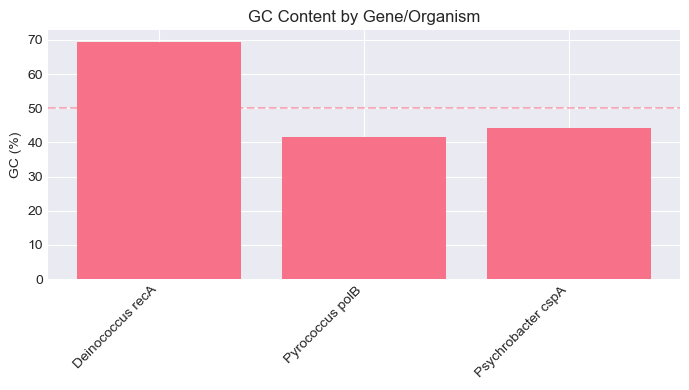

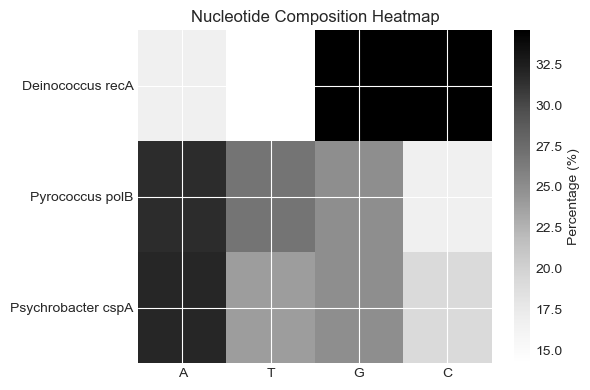

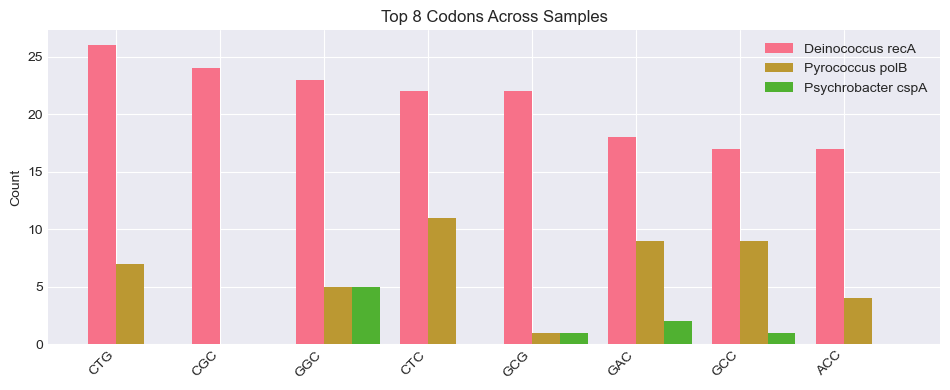

,Deinococcus recA,Pyrococcus polB,Psychrobacter cspA
TTT,0.86,1.00,1.00
TTC,1.14,1.00,1.00
TTA,0.00,0.49,3.00
TTG,0.44,1.35,0.00
TCT,0.33,1.24,2.00
...,...,...,...
GAG,0.93,0.75,0.40
GGT,0.00,0.88,2.00
GGC,2.56,0.49,1.67
GGA,0.44,1.66,0.33


In [ ]:
sequence_genes = {
    "Deinococcus recA": recA,   # from fetch_cds(...)
    "Pyrococcus polB": polB,
    "Psychrobacter cspA": cspA,

}
df, dinucs, codons, rscu = run_sequence_analysis(sequence_genes)
display(df)  # in Jupyter
plot_gc(df)
plot_nucleotide_heatmap(df)
plot_top_codons(codons, top_n=8)
df_rscu = rscu_table(rscu)
display(df_rscu.round(2))

## Part 5: BLAST - Finding Similar Sequences
- **B**asic **L**ocal **A**lignment **S**earch **T**ool
- Finds regions of similarity between sequences
- Compares your query sequence against a database
- Returns statistical measures of similarity



In this section of the workshop, we'll explore how to analyze **Sanger sequencing** data of the **16S rRNA gene**, one of the most widely used genetic markers in microbial ecology and taxonomy.

**Sanger sequencing** (also known as chain-termination sequencing) is a classical DNA sequencing method that generates relatively short but highly accurate reads. It remains common for verifying gene clones or identifying organisms using the 16S rRNA gene.

The **16S rRNA gene** is part of the small ribosomal subunit in bacteria and archaea. Its conserved regions allow universal amplification, while its variable regions (V1–V9) provide species-level signatures. By comparing 16S sequences to reference databases (e.g., SILVA, RDP, NCBI), we can infer taxonomy and evolutionary relationships.

### What is 16S rRNA?
- Universal marker gene found in all bacteria and archaea
- Highly conserved regions (for primer binding) + variable regions (for identification)
- ~1500 base pairs long
- Used as a "molecular barcode" for microbial identification

This section demonstrates how to:
1. Load a FASTA file containing Sanger 16S sequences.
2. Extract metadata (e.g., sequence IDs, lengths, GC content).
3. Generate summary plots and tables for exploration.


### How BLAST Works:

1. **Breaks your sequence into small "words"** (11 base pairs)
2. **Finds exact matches** in the database
3. **Extends matches** in both directions
4. **Scores alignments** based on matches/mismatches
5. **Reports statistically significant** matches

### Key BLAST Statistics:

| Metric | What it means | Good values |
|--------|--------------|-------------|
| **% Identity** | How similar sequences are | >97% for same species |
| **E-value** | Probability of random match | <1e-10 |
| **Bit Score** | Alignment quality score | Higher is better |
| **Coverage** | How much of query aligns | >90% |

<div>
<img src="16S-rRNA-Gene-Variable-Regions.webp" width="500"/>
</div>


Now let's work with a real scenario: You've isolated a microorganism from a Mars analog site (e.g., Iceland) and sequenced its 16S rRNA gene.

In [2]:
def blast_sequence(sequence, seq_id="Query"):
    """
    Perform BLAST search for a single sequence.
    
    Parameters:
    -----------
    sequence : str
        DNA sequence to search
    seq_id : str
        Identifier for the sequence
    
    Returns:
    --------
    list : Top BLAST hits with key information
    """
    print(f"🔍 Searching for {seq_id}...")
    
    try:
        # Submit BLAST query to NCBI
        result_handle = NCBIWWW.qblast(
            "blastn",                    # Program
            "core_nt",         # Database
            sequence,                     # Query sequence
            megablast=True,              # Use megablast for speed
            hitlist_size=5,              # Return top 5 hits
            expect=1e-10                 # E-value threshold
        )
        
        # Parse the results
        blast_record = NCBIXML.read(result_handle)
        
        # Extract top hits
        hits = []
        for alignment in blast_record.alignments[:5]:  # Top 5 hits
            for hsp in alignment.hsps:
                # Calculate percent identity
                percent_identity = (hsp.identities / hsp.align_length) * 100
                
                # Extract organism name from title
                organism = alignment.title.split('|')[-1].strip()
                if len(organism) > 80:
                    organism = organism[:80] + "..."
                
                hits.append({
                    'Sequence_ID': seq_id,
                    'Organism': organism,
                    'Percent_Identity': round(percent_identity, 2),
                    'Alignment_Length': hsp.align_length,
                    'E_value': hsp.expect,
                    'Bit_Score': round(hsp.bits, 1)
                })
                break  # Only take first HSP per alignment
        
        print(f"✓ Found {len(hits)} hits for {seq_id}")
        return hits
        
    except Exception as e:
        print(f"❌ Error searching {seq_id}: {str(e)}")
        return []

In [5]:
# Read sequences from FASTA file
sequences = list(SeqIO.parse('workshop_sequences.fasta', 'fasta'))

print(f"📊 Analyzing {len(sequences)} sequences...\n")
print("="*50)

# Store all results
all_results = []

# Process each sequence
for i, seq_record in enumerate(sequences, 1):
    # Run BLAST
    hits = blast_sequence(str(seq_record.seq), seq_record.id)
    all_results.extend(hits)
    
    # Add delay between searches (be nice to NCBI!)
    if i < len(sequences):
        print("⏳ Waiting 3 seconds before next search...\n")
        time.sleep(3)

print("="*50)
print(f"\n✅ Analysis complete! Total hits: {len(all_results)}")

📊 Analyzing 2 sequences...

🔍 Searching for B03_lvs_13_GM5F_GM5F_5701493_029.ab1...
✓ Found 5 hits for B03_lvs_13_GM5F_GM5F_5701493_029.ab1
⏳ Waiting 3 seconds before next search...

🔍 Searching for A03_lvs_12_GM5F_GM5F_5701493_031.ab1...
✓ Found 5 hits for A03_lvs_12_GM5F_GM5F_5701493_031.ab1

✅ Analysis complete! Total hits: 10


In [6]:
df_results = pd.DataFrame(all_results)

# Display the results
print("🔬 BLAST Results Summary:\n")
print(df_results.to_string(index=False))

# Save to CSV
df_results.to_csv('blast_results.csv', index=False)

🔬 BLAST Results Summary:

                         Sequence_ID                                                                            Organism  Percent_Identity  Alignment_Length  E_value  Bit_Score
B03_lvs_13_GM5F_GM5F_5701493_029.ab1 Brevibacillus borstelensis strain L045_R2A_50 16S ribosomal RNA gene, partial se...            100.00              1120      0.0     1929.0
B03_lvs_13_GM5F_GM5F_5701493_029.ab1 Brevibacillus borstelensis gene for 16S ribosomal RNA, partial sequence, strain:...             95.04              1049      0.0     1668.6
B03_lvs_13_GM5F_GM5F_5701493_029.ab1 Brevibacillus borstelensis strain MLTSA3045-2 16S ribosomal RNA gene, partial se...             95.45              1032      0.0     1663.1
B03_lvs_13_GM5F_GM5F_5701493_029.ab1     Brevibacillus borstelensis strain 90v4 16S ribosomal RNA gene, partial sequence             95.44              1031      0.0     1661.3
B03_lvs_13_GM5F_GM5F_5701493_029.ab1 Brevibacillus borstelensis strain HANSDAJNRI2R 16S r

In [8]:
# Create interpretation summary
print("🧬 INTERPRETATION GUIDE\n")
print("="*60)

for seq_id in df_results['Sequence_ID'].unique():
    # Get top hit for this sequence
    top_hit = df_results[df_results['Sequence_ID'] == seq_id].iloc[0]
    
    print(f"\n📌 {seq_id}")
    print(f"   Top match: {top_hit['Organism'][:60]}...")
    print(f"   Identity: {top_hit['Percent_Identity']}%")
    print(f"   E-value: {top_hit['E_value']:.2e}")
    
    # Interpret the identity percentage
    identity = top_hit['Percent_Identity']
    if identity > 99:
        interpretation = "Same species/strain (>99% identity)"
    elif identity >= 97:
        interpretation = "Same species (97-99% identity)"
    elif identity >= 95:
        interpretation = "Same genus (95-97% identity)"
    else:
        interpretation = "Different genus or potentially novel (<95% identity)"
    
    print(f"   💡 Interpretation: {interpretation}")

print("\n" + "="*60)
print("\n📚 Next steps:")
print("   1. Verify organism identification with multiple genes if needed")
print("   2. Check if these organisms are expected in your environment")
print("   3. Consider ecological roles of identified taxa")
print("   4. Compare community composition across samples")

🧬 INTERPRETATION GUIDE


📌 B03_lvs_13_GM5F_GM5F_5701493_029.ab1
   Top match: Brevibacillus borstelensis strain L045_R2A_50 16S ribosomal ...
   Identity: 100.0%
   E-value: 0.00e+00
   💡 Interpretation: Same species/strain (>99% identity)

📌 A03_lvs_12_GM5F_GM5F_5701493_031.ab1
   Top match: Bacillus licheniformis strain S042_TSB_50_2 16S ribosomal RN...
   Identity: 100.0%
   E-value: 0.00e+00
   💡 Interpretation: Same species/strain (>99% identity)


📚 Next steps:
   1. Verify organism identification with multiple genes if needed
   2. Check if these organisms are expected in your environment
   3. Consider ecological roles of identified taxa
   4. Compare community composition across samples



### Identity Thresholds for 16S rRNA:

| % Identity | Taxonomic Level | Interpretation |
|------------|----------------|----------------|
| >99% | Same strain | Exact or nearly exact match |
| 97-99% | Same species | Standard species boundary |
| 95-97% | Same genus | Closely related species |
| 90-95% | Same family | More distant relationship |
| <90% | Different family | Distant or potentially novel |




## Part 7: Challenge Exercise

### Your Mission: Mars Sample Analysis

The Challenge Scenario

Your team has received MinION sequencing data from a Mars sample return mission. The samples were collected from:

2 meters below the Martian regolith

Near a recurring slope lineae (possible liquid water)

Temperature range: -70°C to 0°C

High perchlorate concentration (0.5-1%)

pH ~7.5-8.5

You've recovered several DNA-like sequences. How do you determine if they represent:

Earth contamination (despite sterilization protocols)

False positives (abiotic polymer assembly)

True Martian life

## Workshop Wrap-Up

### Key Takeaways:

1. **Extremophiles as Astrobiological Models**: Earth's extremophiles help us understand potential life on other worlds

2. **Sequence Signatures**: Different environments leave distinctive marks in DNA sequences

3. **Biosignatures**: We can identify molecular patterns that indicate biological origin

4. **Computational Tools**: Python and NCBI resources are powerful for astrobiology research

### Next Week Preview:
We'll dive into QIIME2 and analyze real microbiome data from Mars analog sites!

### Homework:
1. Find and analyze a sequence from an extremophile of your choice
2. Research one Mars analog site on Earth
3. Install QIIME2 (instructions provided separately)

### Resources:
- NCBI BLAST: https://blast.ncbi.nlm.nih.gov/
- Biopython Tutorial: https://biopython.org/wiki/Documentation
- NASA Astrobiology: https://astrobiology.nasa.gov/
